# Setting Up Environment
We will be using Tensorflow 1.15.0

In [3]:
import tensorflow as tf
print( tf.__version__)

1.15.0


In [0]:
import os

from keras.utils import HDF5Matrix
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.xception import Xception
import tensorflow_datasets

import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, cm
import random
import time

import seaborn as sns
import pandas as pd
import gc


In [4]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Data 

*Run Uploading Data section in `BaselineCNN_andDataSetup.ipynb` before this code so correct data is saved within your Google Drive*


In [0]:
# import the pictures
DATA_DIR = "/content/drive/My Drive/pcamv1_no_gz"

x_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_x.h5'), 'x')
y_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_y.h5'), 'y')

In [0]:
# load baseline model
cnn_baseline = tf.keras.models.load_model('/content/drive/My Drive/models/baseline_model.h5')

# load ResNet model
#res_model = tf.keras.models.load_model('/content/drive/My Drive/models/res_model.h5')

# Interpretability and Data Visualizations


In [0]:
# predit with model on validation set
sample_data_generator =  ImageDataGenerator(
              preprocessing_function=lambda x: x/255.)

test_predictions = cnn_baseline.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

#create dataframe
df_test = pd.DataFrame({'actual':y_test[:].flatten(), 'probabilities':test_predictions.flatten()})

## Occlusion Map

The following code can be used to create occulsion maps.  Implementation of the occlusions was taken from [this kernel](https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps) and impmented after [Visualizing and Understanding Convolutional Networks (2013)](https://arxiv.org/abs/1311.2901 ).

Since this is a binary classificaition task, the heat maps created plot the predicted probablity of the image when each square is greyed out.  

The code below automates the calculations and plotting so that multiple examples can be analized.

In [0]:
#occlusion function 
# framework of this implementation of occlusion was found on this kernel:
# https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps
# ONLY iter_occlusion function is taken from this kernel

def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

In [0]:
# function for creating heatmaps
def create_heatmap(model, examples_df):
  """ This takes in the model for predicting + a dataframe with actual class + probabilites""" 
  occlusion_size = 4
  heatmaps = []
  for inx in list(examples_df.index):
      # select an image
      img = x_test[inx]

      #start with blank heatmap
      heatmap = np.zeros((96, 96), np.float32)

      for n, (x, y, img_float) in enumerate(iter_occlusion(img, size=occlusion_size)):   
          out = model.predict_generator(sample_data_generator.flow(img_float.reshape(1, 96, 96, 3), batch_size=1, shuffle=False),
                          steps=1)
          heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0]
      heatmaps.append(heatmap)
  return heatmaps

In [0]:
# function for plotting heatmaps
def plot_maps(heatmaps, examples_df):
  """ This takes in the heatmaps + a dataframe with actual class + probabilites""" 
  fig=plt.figure(figsize=(8, 8))
  i = 1
  for map_plot, inx in zip(heatmaps, list(examples_df.index) ):
      img = x_test[inx]
      fig.add_subplot(2, 5, i)
      plt.title(f"Prediction: {round(float(examples_df.loc[[inx]].probabilities), 3 )}")
      plt.imshow(img.mean(axis=2), cmap=cm.gray)
      plt.pcolormesh(map_plot, cmap=plt.cm.jet, alpha=0.20)
      plt.axis('off')
      i = i + 1
      
  plt.clim(0,1)

  for inx in list(examples_df.index):
      img = x_test[inx]
      fig.add_subplot(2, 5, i)
      plt.title(f"Class: {int(examples_df.loc[[inx]].actual)}")
      plt.imshow(img)
      plt.axis('off')
      i = i + 1

  #plt.colorbar().solids.set(alpha=1)
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()

#### False Negative

In [13]:
# pick some examples to look at (False Negatives Example)
false_negative = df_test[(df_test.actual == 1) & (df_test.probabilities < 0.5)] \
                                            .sample(5).sort_values('probabilities')
false_negative

,actual,probabilities
25921,1,0.004233
2095,1,0.008927
20584,1,0.033877
26743,1,0.289813
11218,1,0.338791


In [0]:
heatmaps_fn = create_heatmap(cnn_baseline, false_negative)

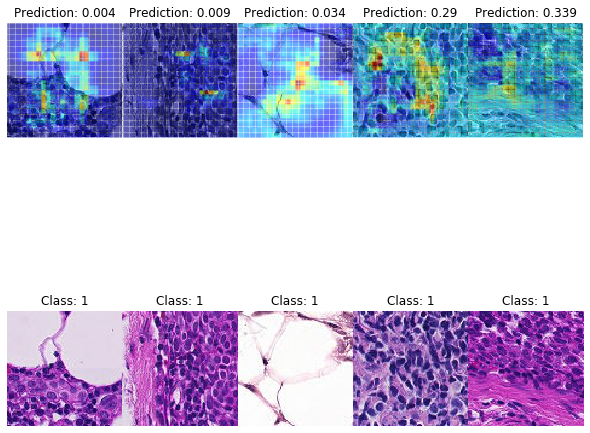

In [22]:
plot_maps(heatmaps_fn, false_negative)

#### True Positives

In [25]:
# pick some examples to look at (False Negatives Example)
true_positives = df_test[(df_test.actual == 1) & (df_test.probabilities > 0.5)] \
                                            .sample(5).sort_values('probabilities')
true_positives

,actual,probabilities
26053,1,0.554957
24741,1,0.809681
24019,1,0.991511
18182,1,0.996871
2208,1,0.999897


In [0]:
heatmaps_tp = create_heatmap(cnn_baseline, true_positives)

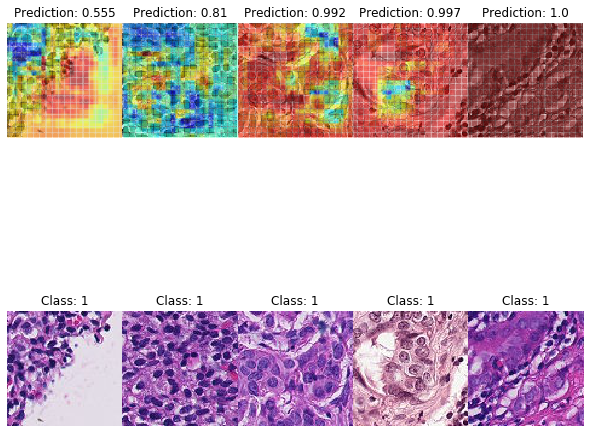

In [27]:
plot_maps(heatmaps_tp, true_positives)

#### False Positive

In [29]:
# pick some examples to look at (False Negatives Example)
false_positive = df_test[(df_test.actual == 0) & (df_test.probabilities > 0.5)] \
                                            .sample(5).sort_values('probabilities')
false_positive

,actual,probabilities
26393,0,0.601583
31084,0,0.860247
1379,0,0.875103
20236,0,0.904600
26259,0,0.978697


In [0]:
heatmaps_fp = create_heatmap(cnn_baseline, false_positive)

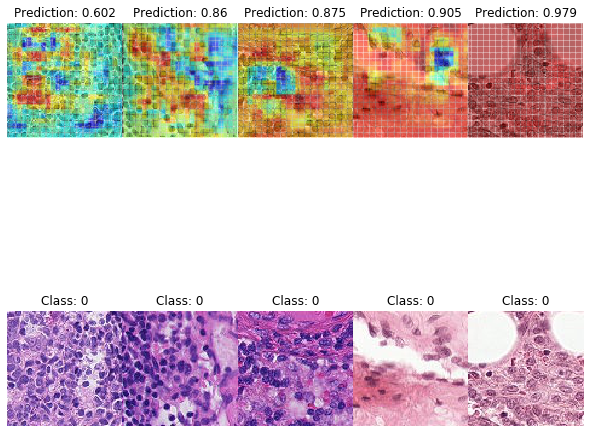

In [31]:
plot_maps(heatmaps_fp, false_positive)

### True Negatives 

In [39]:
# pick some examples to look at (False Negatives Example)
true_negatives = df_test[(df_test.actual == 0) & (df_test.probabilities < 0.5)] \
                                            .sample(5).sort_values('probabilities')
true_negatives

,actual,probabilities
13479,0,0.006132
28316,0,0.043340
20281,0,0.117336
14234,0,0.259127
19666,0,0.375922


In [0]:
heatmaps_tn = create_heatmap(cnn_baseline, true_negatives)

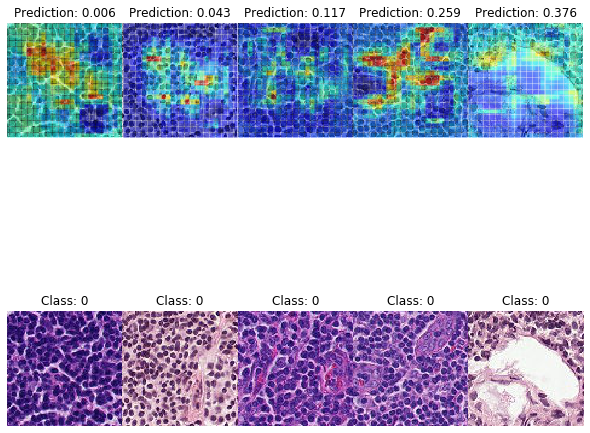

In [41]:
plot_maps(heatmaps_tn, true_negatives)

## Visualizing Kerels

Looking at what the actual kernels output for a particular example.  This is another approach for interpreting CNNs.  However, the output of the CNN layers is not always intuitive, expecially with this dataset.

In [0]:
# new model for extracting output from kernel
new_model = tf.keras.models.Model([cnn_baseline.inputs],  [cnn_baseline.get_layer("conv2d_41").output] )
# new_model.summary()

#### First Example: True Positive

We'll first do an example with the last positive prediction with the heatmap created above.  This example showes that the averaged output of the last convolutional layer in the CNN can be a good gauge as to where the model is "paying attention."

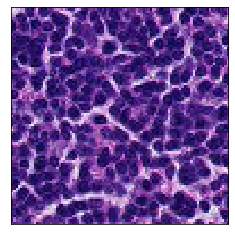

In [55]:
#example image
img_row = true_negatives.iloc[[0]] # take first example for true negatives subset
img = x_test[img_row.index[0]]

#plot
ax = plt.subplot(1, 1, 1)
imshow(img) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [0]:
# predit with model on validation set
sample_data_generator = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.)

test_predictions = new_model.predict_generator(sample_data_generator.flow(np.expand_dims(img, 0), batch_size=1, shuffle=False), steps=1)

In [0]:
#define function for plotting multiple filters
def show_images(images, rows, columns):
    #n = len(images)
    f = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        f.add_subplot(rows, columns, i)
        imshow(images[i])
    plt.show()

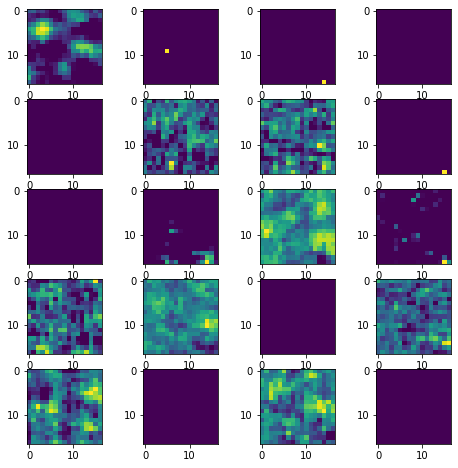

In [58]:
#iterate through filters and plot
filter_outputs = [test_predictions[0, :, :, i] for i in range(0,64)]

#show first 20 kernels
show_images(filter_outputs, 5, 4)

This doesn't give us much info, so let's aggreagate the output of all the kernels to see the 'average output'.

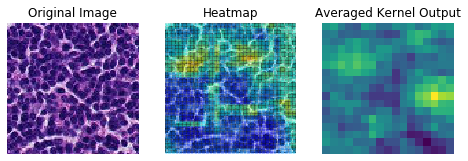

In [59]:
mean_filters = np.mean(filter_outputs, axis=0)


fig=plt.figure(figsize=(8, 8))

#plot origonal image
fig.add_subplot(1, 3, 1)
plt.title(f"Original Image")
plt.imshow(img)
plt.axis('off')

#plot heatmap made before
fig.add_subplot(1, 3, 2)
plt.title(f"Heatmap")
plt.imshow(img.mean(axis=2), cmap=cm.gray)
plt.pcolormesh(heatmaps_tn[-1], cmap=plt.cm.jet, alpha=0.20)
plt.axis('off')
plt.clim(0,1)

#plot aggreagated kernels
fig.add_subplot(1, 3, 3)
plt.title(f"Averaged Kernel Output")
imshow(mean_filters)
plt.axis('off')

plt.show()

#plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


#### Kernel Outputs and Heatmap for True Positives

Now we'll look at new true positives' heatmaps along with the averaged kernel outputs.

In [0]:
# create a function for calculating avg kernel output
def create_avg_kernels(cnn_baseline, examples_df):

  avg_filters = []
  for indx in list(examples_df.index):
    img = x_test[indx]

    # predit with model on validation set
    test_predictions = new_model.predict_generator(sample_data_generator.flow(np.expand_dims(img, 0), 
                                                                          batch_size=1,
                                                                          shuffle=False), steps=1)

    filter_outputs = [test_predictions[0, :, :, i] for i in range(0,64)]
    avg_filters.append(np.mean(filter_outputs, axis=0))
  return avg_filters

In [0]:
# create a function for plotting heat map and averaged kernel outputs
def heat_and_kernel_plot(heatmaps, avg_kerels, examples_df):

  rows = len(heatmaps)
  i = 1

  fig=plt.figure(figsize=(8, 8))
  for heatmap, avg_kernel, inx in zip(heatmaps, avg_kerels, list(examples_df.index)):
    img = x_test[inx]

    #plot origonal image
    fig.add_subplot(rows, 3, i)
    plt.title(f"Class: {int(examples_df.loc[[inx]].actual)}")
    plt.imshow(img)
    plt.axis('off')
    i = i + 1

    #plot heatmap made before
    fig.add_subplot(rows, 3, i)
    plt.title(f"")
    plt.imshow(img.mean(axis=2), cmap=cm.gray)
    plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.20)
    plt.axis('off')
    plt.clim(0,1)
    i = i + 1

    #plot aggreagated kernels
    fig.add_subplot(rows, 3, i)
    plt.title(f"Prediction: {round(float(examples_df.loc[[inx]].probabilities), 3 )}")
    imshow(avg_kernel)
    plt.axis('off')
    i = i + 1
    
  plt.subplots_adjust(wspace=0, hspace=.18, left=0, right=1, bottom=0, top=1)
  plt.show()

In [62]:
# take a sample of true positives
true_positives = df_test[(df_test.actual == 1) & (df_test.probabilities > 0.5)] \
                                            .sample(5, random_state=77).sort_values('probabilities')
true_positives

,actual,probabilities
4245,1,0.611232
20634,1,0.840385
23867,1,0.960937
28834,1,0.988757
23147,1,0.998262


In [0]:
# get heatmaps
heatmaps_tp = create_heatmap(cnn_baseline, true_positives)

In [0]:
# get avg kernels
avg_kernals_tp = create_avg_kernels(cnn_baseline, true_positives)

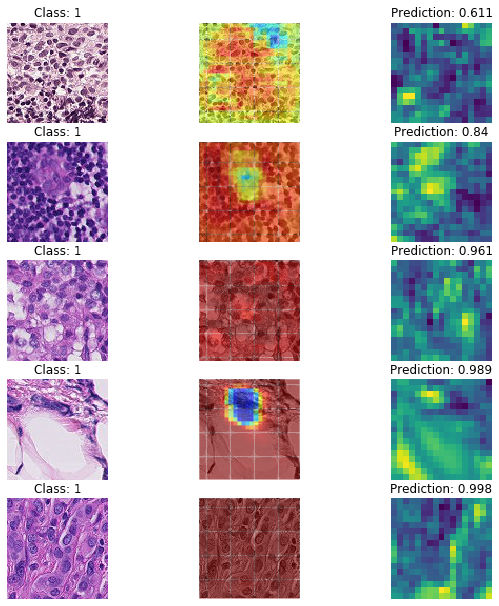

In [65]:
heat_and_kernel_plot(heatmaps_tp, avg_kernals_tp, true_positives)